In [44]:
import sys
import config
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [45]:
print("[INFO] loading dataset...")
rows = open(config.ANNOTS_PATH, encoding='utf-8-sig').read().strip().split("\n")

data = []
targets = []
filenames = []

[INFO] loading dataset...


In [46]:
rows

['h2213nj_1.jpg,263,778,592,917',
 'h2213nj_2.jpg,185,753,417,851',
 'h2213nj_3.jpg,480,612,828,813',
 'h2213nj_4.jpg,484,422,819,616',
 'h2213nj_5.jpg,277,602,632,773',
 'h2213nj_6.jpg,340,579,713,748',
 'h2213nj_7.jpg,426,652,795,779',
 'h2213nj_8.jpg,332,649,668,795',
 'h2213nj_9.jpg,255,649,558,786',
 'h5560yq_1.jpg,257,311,892,717',
 'h5560yq_2.jpg,197,681,830,948',
 'h6314wi_1.jpg,196,686,492,804',
 'h6314wi_2.jpg,281,580,696,751',
 'h6314wi_3.jpg,315,745,727,1057',
 'h6314wi_4.jpg,222,731,513,949',
 'h6314wi_4_crop.jpg,173,194,463,412',
 'h6314wi_5.jpg,287,540,755,763',
 'h6314wi_6.jpg,307,534,687,694',
 'h6314wi_7.jpg,212,595,588,781',
 'h6314wi_8.jpg,393,821,870,1108',
 'h6379nw_1.jpg,123,452,782,853',
 'h6379nw_2.jpg,316,354,1009,653',
 'h6176ol_1.jpg,506,851,898,1117',
 'h6176ol_2.jpg,500,797,829,1015',
 'h6176ol_3.jpg,150,578,742,948',
 'h6176ol_4.jpg,280,428,655,788']

In [47]:
# loop over the rows
for row in rows:
	# break the row into the filename and bounding box coordinates
	row = row.split(",")
	(filename, startX, startY, endX, endY) = row

	imagePath = os.path.sep.join([config.IMAGES_PATH, filename])
	image = cv2.imread(imagePath)

	# if image is None:
	# 	print(f"Error: Unable to read image{imagePath}")
	# continue

	(h, w) = image.shape[:2]

	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
	startX = float(startX) / w
	startY = float(startY) / h
	endX = float(endX) / w
	endY = float(endY) / h

	# load the image and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)

	# update our list of data, targets, and filenames
	data.append(image)
	targets.append((startX, startY, endX, endY))
	filenames.append(filename)

In [48]:
startX, startY, endX, endY


(0.2734375, 0.334375, 0.6396484375, 0.615625)

In [49]:
startX = int(float(startX) * w)
startY = int(float(startY) * h)
endX = int(float(endX) * w)
endY = int(float(endY) * h)

In [50]:
print(f"Coordinates: ({startX}, {startY}) to ({endX}, {endY})")

Coordinates: (280, 428) to (655, 788)


In [53]:
filenames

['h2213nj_1.jpg',
 'h2213nj_2.jpg',
 'h2213nj_3.jpg',
 'h2213nj_4.jpg',
 'h2213nj_5.jpg',
 'h2213nj_6.jpg',
 'h2213nj_7.jpg',
 'h2213nj_8.jpg',
 'h2213nj_9.jpg',
 'h5560yq_1.jpg',
 'h5560yq_2.jpg',
 'h6314wi_1.jpg',
 'h6314wi_2.jpg',
 'h6314wi_3.jpg',
 'h6314wi_4.jpg',
 'h6314wi_4_crop.jpg',
 'h6314wi_5.jpg',
 'h6314wi_6.jpg',
 'h6314wi_7.jpg',
 'h6314wi_8.jpg',
 'h6379nw_1.jpg',
 'h6379nw_2.jpg',
 'h6176ol_1.jpg',
 'h6176ol_2.jpg',
 'h6176ol_3.jpg',
 'h6176ol_4.jpg']

In [54]:
image

array([[[213., 236., 156.],
        [213., 236., 156.],
        [213., 236., 154.],
        ...,
        [ 77., 124., 104.],
        [ 65., 114.,  84.],
        [ 57., 110.,  92.]],

       [[213., 236., 156.],
        [212., 235., 155.],
        [214., 237., 157.],
        ...,
        [ 60., 109.,  87.],
        [ 59., 104.,  84.],
        [131., 186., 167.]],

       [[214., 238., 154.],
        [213., 237., 153.],
        [214., 238., 154.],
        ...,
        [ 60., 110.,  81.],
        [ 59., 108.,  87.],
        [145., 207., 186.]],

       ...,

       [[168., 142., 115.],
        [166., 140., 113.],
        [159., 134., 104.],
        ...,
        [174., 155., 141.],
        [195., 173., 160.],
        [166., 140., 125.]],

       [[168., 142., 115.],
        [165., 139., 112.],
        [152., 127.,  97.],
        ...,
        [177., 154., 136.],
        [178., 160., 146.],
        [186., 165., 148.]],

       [[160., 133., 104.],
        [166., 143., 112.],
        [169., 1

In [55]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.1)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(config.TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [56]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [57]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=config.INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

[INFO] saving object detector model...


c:\Users\ravin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


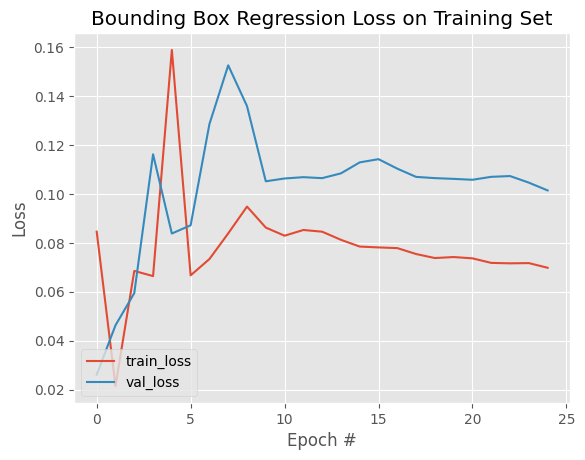

In [58]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.MODEL_PATH, save_format="h5")

# plot the model training history
N = config.NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)